Import packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
!pip install tensorflow

Import Dataset


In [2]:
data = pd.read_csv('spotify_data.csv')

Dataset null check and Cleaning

In [3]:
data.info()

# Get the number of rows and columns in the dataset
print(data.shape)

print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159764 non-null  object 
 2   track_name        1159764 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

Column Dropping

In [4]:
print(data.columns)

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')


In [5]:
columns_to_drop2 = ['Unnamed: 0', 'artist_name', 'track_name','track_id','genre', 'year', 'energy', 'key']
data2 = data.drop(columns=columns_to_drop2)

In [6]:
data2.info()
numerical_summary = data2.describe()
print(numerical_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   popularity        1159764 non-null  int64  
 1   danceability      1159764 non-null  float64
 2   loudness          1159764 non-null  float64
 3   mode              1159764 non-null  int64  
 4   speechiness       1159764 non-null  float64
 5   acousticness      1159764 non-null  float64
 6   instrumentalness  1159764 non-null  float64
 7   liveness          1159764 non-null  float64
 8   valence           1159764 non-null  float64
 9   tempo             1159764 non-null  float64
 10  duration_ms       1159764 non-null  int64  
 11  time_signature    1159764 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 106.2 MB
         popularity  danceability      loudness          mode   speechiness  \
count  1.159764e+06  1.159764e+06  1.159764e+06  1.159764e+06  1.15976

In [7]:
missing_values = data2.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


### Multicollinearity Test

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Preparing the data for VIF calculation: excluding the target variable and adding a constant for the intercept
X = data2.drop('popularity', axis=1)
X = X._get_numeric_data()  # ensuring all variables are numeric
X['Intercept'] = 1

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Interpretation: A VIF above 5 or 10 indicates high multicollinearity
vif_data.sort_values('VIF', ascending=False)

,Feature,VIF
11,Intercept,115.337405
1,loudness,2.152331
4,acousticness,1.781868
7,valence,1.542421
0,danceability,1.514696
5,instrumentalness,1.365243
6,liveness,1.143956
3,speechiness,1.129650
8,tempo,1.094829
10,time_signature,1.062648


Data Transformation

In [8]:
# Log transformation
for col in ['speechiness', 'instrumentalness', 'liveness']:
    data2[col + '_log'] = np.log1p(data2[col])

# Standardize features with large range or significant outliers
scaler = StandardScaler()
data2[['loudness', 'tempo', 'duration_ms']] = scaler.fit_transform(data2[['loudness', 'tempo', 'duration_ms']])

# Performing one-hot encoding on 'key', 'mode', and 'time_signature'
# This will create a new column for each unique value in each of these columns
data2_encoded = pd.get_dummies(data2, columns=[ 'mode', 'time_signature'], prefix=[ 'mode', 'time_sig'])


In [9]:
data2.drop(columns=[ 'speechiness', 'instrumentalness', 'liveness'], inplace=True)

In [10]:
# Drop the original untransformed columns that we applied log transformation to
data2_encoded.drop(columns=[ 'speechiness', 'instrumentalness', 'liveness'], inplace=True)


In [11]:
print(data2_encoded.columns)

Index(['popularity', 'danceability', 'loudness', 'acousticness', 'valence',
       'tempo', 'duration_ms', 'speechiness_log', 'instrumentalness_log',
       'liveness_log', 'mode_0', 'mode_1', 'time_sig_0', 'time_sig_1',
       'time_sig_3', 'time_sig_4', 'time_sig_5'],
      dtype='object')


Box Cox Transformation

In [12]:
from scipy import stats

# Check for any non-positive values
if (data2_encoded['duration_ms'] <= 0).any():
    # Add a constant to shift all values in the column to be positive
    data2_encoded['duration_ms'] += 1 - data2_encoded['duration_ms'].min()

# Check for NaN values and handle them
data2_encoded['duration_ms'] = data2_encoded['duration_ms'].fillna(data2_encoded['duration_ms'].mean())

# Now apply Box-Cox transformation
data2_encoded['duration_ms_boxcox'], _ = stats.boxcox(data2_encoded['duration_ms'])

# Repeat the process for other variables
if (data2_encoded['speechiness_log'] <= 0).any():
    data2_encoded['speechiness_log'] += 1 - data2_encoded['speechiness_log'].min()

data2_encoded['speechiness_log'] = data2_encoded['speechiness_log'].fillna(data2_encoded['speechiness_log'].mean())

data2_encoded['speechiness_log_boxcox'], _ = stats.boxcox(data2_encoded['speechiness_log'])

if (data2_encoded['liveness_log'] <= 0).any():
    data2_encoded['liveness_log'] += 1 - data2_encoded['liveness_log'].min()

data2_encoded['liveness_log'] = data2_encoded['liveness_log'].fillna(data2_encoded['liveness_log'].mean())

data2_encoded['liveness_log_boxcox'], _ = stats.boxcox(data2_encoded['liveness_log'])


In [ ]:
data2_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   popularity              1159764 non-null  int64  
 1   danceability            1159764 non-null  float64
 2   loudness                1159764 non-null  float64
 3   acousticness            1159764 non-null  float64
 4   valence                 1159764 non-null  float64
 5   tempo                   1159764 non-null  float64
 6   duration_ms             1159764 non-null  float64
 7   speechiness_log         1159764 non-null  float64
 8   instrumentalness_log    1159764 non-null  float64
 9   liveness_log            1159764 non-null  float64
 10  mode_0                  1159764 non-null  uint8  
 11  mode_1                  1159764 non-null  uint8  
 12  time_sig_0              1159764 non-null  uint8  
 13  time_sig_1              1159764 non-null  uint8  
 14  ti

In [13]:
# Drop the untransformed log columns that we applied boxcox transformation to
data2_encoded.drop(columns=[ 'speechiness_log', 'duration_ms', 'liveness_log'], inplace=True)

In [14]:
data2_encoded.head()

,popularity,danceability,loudness,acousticness,valence,tempo,instrumentalness_log,mode_0,mode_1,time_sig_0,time_sig_1,time_sig_3,time_sig_4,time_sig_5,duration_ms_boxcox,speechiness_log_boxcox,liveness_log_boxcox
0,68,0.483,-0.189477,0.6940,0.139,0.403928,0.000000,0,1,0,0,1,0,0,0.738060,0.030161,0.075884
1,50,0.572,-0.229602,0.4770,0.515,0.631465,0.000014,0,1,0,0,0,1,0,0.700301,0.020716,0.068006
2,57,0.409,-0.832360,0.3380,0.145,0.619712,0.000050,0,1,0,0,0,1,0,0.590817,0.024630,0.064142
3,58,0.392,-0.151991,0.8070,0.508,2.806736,0.000000,0,1,0,0,0,1,0,0.824010,0.026833,0.059038
4,54,0.430,0.626931,0.0726,0.217,1.695343,0.019116,1,0,0,0,0,1,0,0.744287,0.023412,0.073742


Drop columns

In [15]:
print(data2_encoded.columns)

Index(['popularity', 'danceability', 'loudness', 'acousticness', 'valence',
       'tempo', 'instrumentalness_log', 'mode_0', 'mode_1', 'time_sig_0',
       'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5',
       'duration_ms_boxcox', 'speechiness_log_boxcox', 'liveness_log_boxcox'],
      dtype='object')


In [16]:
data2_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   popularity              1159764 non-null  int64  
 1   danceability            1159764 non-null  float64
 2   loudness                1159764 non-null  float64
 3   acousticness            1159764 non-null  float64
 4   valence                 1159764 non-null  float64
 5   tempo                   1159764 non-null  float64
 6   instrumentalness_log    1159764 non-null  float64
 7   mode_0                  1159764 non-null  uint8  
 8   mode_1                  1159764 non-null  uint8  
 9   time_sig_0              1159764 non-null  uint8  
 10  time_sig_1              1159764 non-null  uint8  
 11  time_sig_3              1159764 non-null  uint8  
 12  time_sig_4              1159764 non-null  uint8  
 13  time_sig_5              1159764 non-null  uint8  
 14  du

Correlation matrix

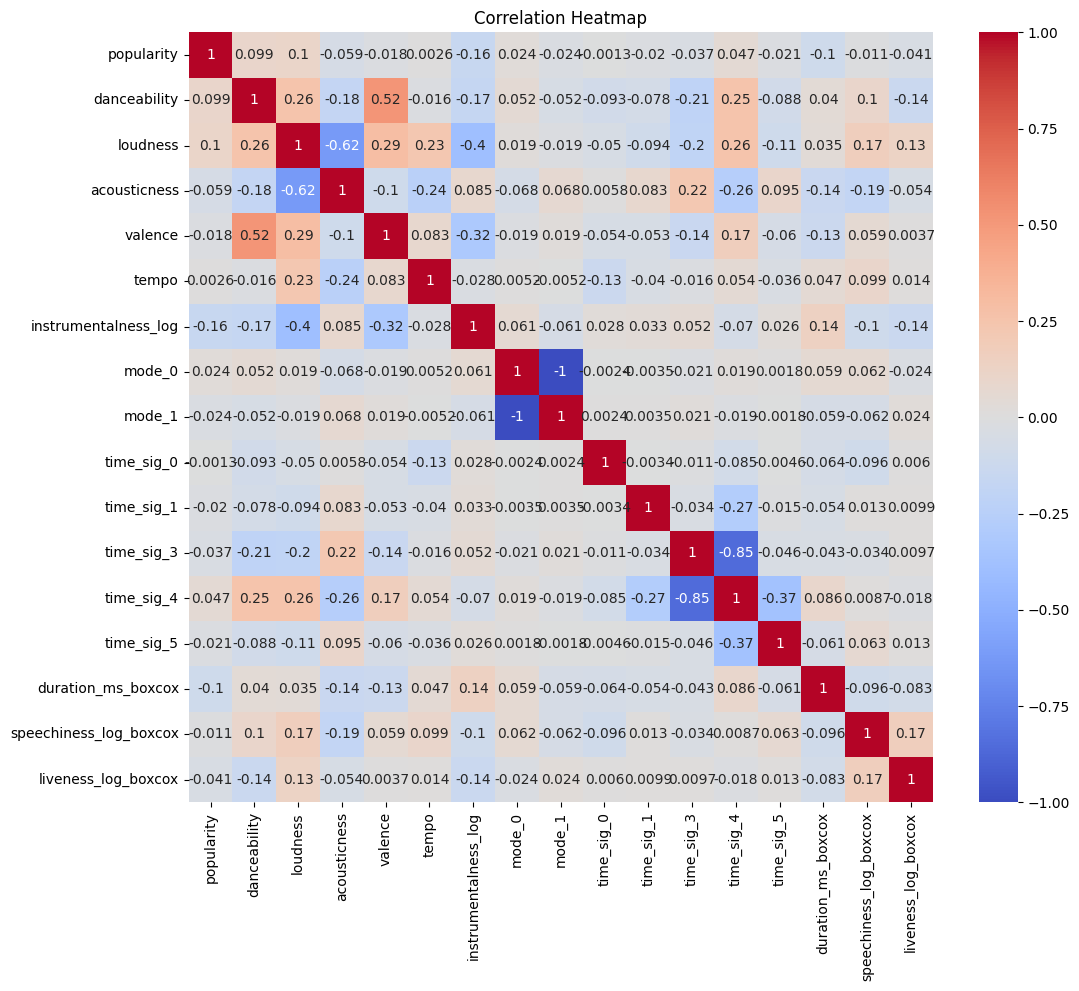

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = data2_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.show()


Feature selection - Mutual Information Score

In [ ]:
numerical_features2_encoded=['danceability', 'loudness', 'acousticness', 'valence', 'tempo', 'instrumentalness_log', 'mode_0', 'mode_1',
       'time_sig_0', 'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5',
       'duration_ms_boxcox', 'speechiness_log_boxcox', 'liveness_log_boxcox']
from sklearn.feature_selection import mutual_info_regression
X = data2_encoded[numerical_features2_encoded]

y = data2_encoded['popularity']
X.fillna(X.mean(), inplace=True)
mi_scores = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)


                   Feature  Mutual Information
13      duration_ms_boxcox            0.040810
4                    tempo            0.022122
5     instrumentalness_log            0.019011
2             acousticness            0.017931
0             danceability            0.016280
1                 loudness            0.015201
14  speechiness_log_boxcox            0.010338
3                  valence            0.007712
15     liveness_log_boxcox            0.006969
10              time_sig_3            0.001580
9               time_sig_1            0.001431
7                   mode_1            0.001365
11              time_sig_4            0.000724
6                   mode_0            0.000271
8               time_sig_0            0.000000
12              time_sig_5            0.000000


Feature selection - F-Score

In [ ]:
import pandas as pd
from sklearn.feature_selection import f_regression


# Assuming 'popularity' is your target variable for regression
y = data2_encoded['popularity']
X = data2_encoded[numerical_features2_encoded]

# Fill missing values with the mean
X.fillna(X.mean(), inplace=True)

# Calculate F-statistics for feature selection
f_scores, _ = f_regression(X, y)

# Create a DataFrame to store feature names and their F-scores
f_scores_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})

# Sort the DataFrame by F-Score in descending order
f_scores_df = f_scores_df.sort_values(by='F-Score', ascending=False)

# Print the DataFrame with feature names and their F-Scores
print(f_scores_df)


                   Feature       F-Score
5     instrumentalness_log  28908.305550
13      duration_ms_boxcox  12845.491209
1                 loudness  12704.955055
0             danceability  11370.148776
2             acousticness   4076.151053
11              time_sig_4   2621.971654
15     liveness_log_boxcox   1929.918997
10              time_sig_3   1552.042713
7                   mode_1    659.373509
6                   mode_0    659.373509
12              time_sig_5    512.474101
9               time_sig_1    482.617452
3                  valence    378.824355
14  speechiness_log_boxcox    140.635837
4                    tempo      7.637441
8               time_sig_0      2.008323


In [ ]:
data2_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   popularity              1159764 non-null  int64  
 1   danceability            1159764 non-null  float64
 2   loudness                1159764 non-null  float64
 3   acousticness            1159764 non-null  float64
 4   valence                 1159764 non-null  float64
 5   tempo                   1159764 non-null  float64
 6   instrumentalness_log    1159764 non-null  float64
 7   mode_0                  1159764 non-null  uint8  
 8   mode_1                  1159764 non-null  uint8  
 9   time_sig_0              1159764 non-null  uint8  
 10  time_sig_1              1159764 non-null  uint8  
 11  time_sig_3              1159764 non-null  uint8  
 12  time_sig_4              1159764 non-null  uint8  
 13  time_sig_5              1159764 non-null  uint8  
 14  du

### Shapiro Wilk Test

In [ ]:
from scipy.stats import shapiro
# Normality Test (Shapiro-Wilk) using a random 1000 sampleS of each audio feature
normality_test_results = pd.DataFrame(columns=['Feature', 'Shapiro_Stat', 'p-value', 'Distribution'])
sample_size = 1000  #  sample size

for col in data2_encoded.columns:  # Excluding the 'Intercept' column
    # Take a random sample of about 30% of the data
    sample = data2_encoded[col].sample(sample_size)
    stat, p = shapiro(sample)
    # Determine if the feature is normally distributed based on p-value
    distribution_status = 'Normally Distributed' if p > 0.05 else 'Not Normally Distributed'
    normality_test_results = normality_test_results.append({'Feature': col, 'Shapiro_Stat': stat, 'p-value': p, 'Distribution': distribution_status}, ignore_index=True)

normality_test_results.set_index('Feature', inplace=True)
normality_test_results

,Shapiro_Stat,p-value,Distribution
Feature,,,
popularity,0.928513,2.019097e-21,Not Normally Distributed
danceability,0.986393,5.089842e-08,Not Normally Distributed
loudness,0.821634,6.691237e-32,Not Normally Distributed
acousticness,0.803825,4.052830e-33,Not Normally Distributed
valence,0.955304,6.776166e-17,Not Normally Distributed
tempo,0.986350,4.878958e-08,Not Normally Distributed
instrumentalness_log,0.680553,9.839161e-40,Not Normally Distributed
mode_0,0.611537,1.453147e-42,Not Normally Distributed
mode_1,0.623606,4.226316e-42,Not Normally Distributed


### D'Agostino's Test

In [ ]:
from scipy.stats import normaltest
import pandas as pd



target_column = 'popularity'

# Get the numerical columns excluding the target variable
numerical_columns = data2_encoded.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col != target_column]

# Initialize a DataFrame to hold the normality test results
Agostino_test_results = pd.DataFrame(columns=['Feature','p-value', 'Statistic','Distribution'])

# Perform D'Agostino's K^2 test for each numerical column
for column in numerical_columns:
    data = data2_encoded[column]
    stat, p_value = normaltest(data)
    distribution_status = 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'

    # Append the results to the DataFrame
    Agostino_test_results = Agostino_test_results.append({
        'Feature': column,
        'Statistic': stat,
        'p-value': p_value,
        'Distribution': distribution_status }, ignore_index=True)

# Display the results
Agostino_test_results


,Feature,p-value,Statistic,Distribution
0,danceability,0.0,39147.460992,Not Normally Distributed
1,loudness,0.0,448021.367051,Not Normally Distributed
2,acousticness,0.0,472521.071172,Not Normally Distributed
3,valence,0.0,422192.590745,Not Normally Distributed
4,tempo,0.0,11104.039501,Not Normally Distributed
5,instrumentalness_log,0.0,409784.663828,Not Normally Distributed
6,duration_ms_boxcox,0.0,48917.113723,Not Normally Distributed
7,speechiness_log_boxcox,0.0,123198.662839,Not Normally Distributed
8,liveness_log_boxcox,0.0,233598.429976,Not Normally Distributed


In [ ]:
data2_encoded.columns

Index(['popularity', 'danceability', 'loudness', 'acousticness', 'valence',
       'tempo', 'instrumentalness_log', 'mode_0', 'mode_1', 'time_sig_0',
       'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5',
       'duration_ms_boxcox', 'speechiness_log_boxcox', 'liveness_log_boxcox'],
      dtype='object')

Histogram and Box Plot Distribution

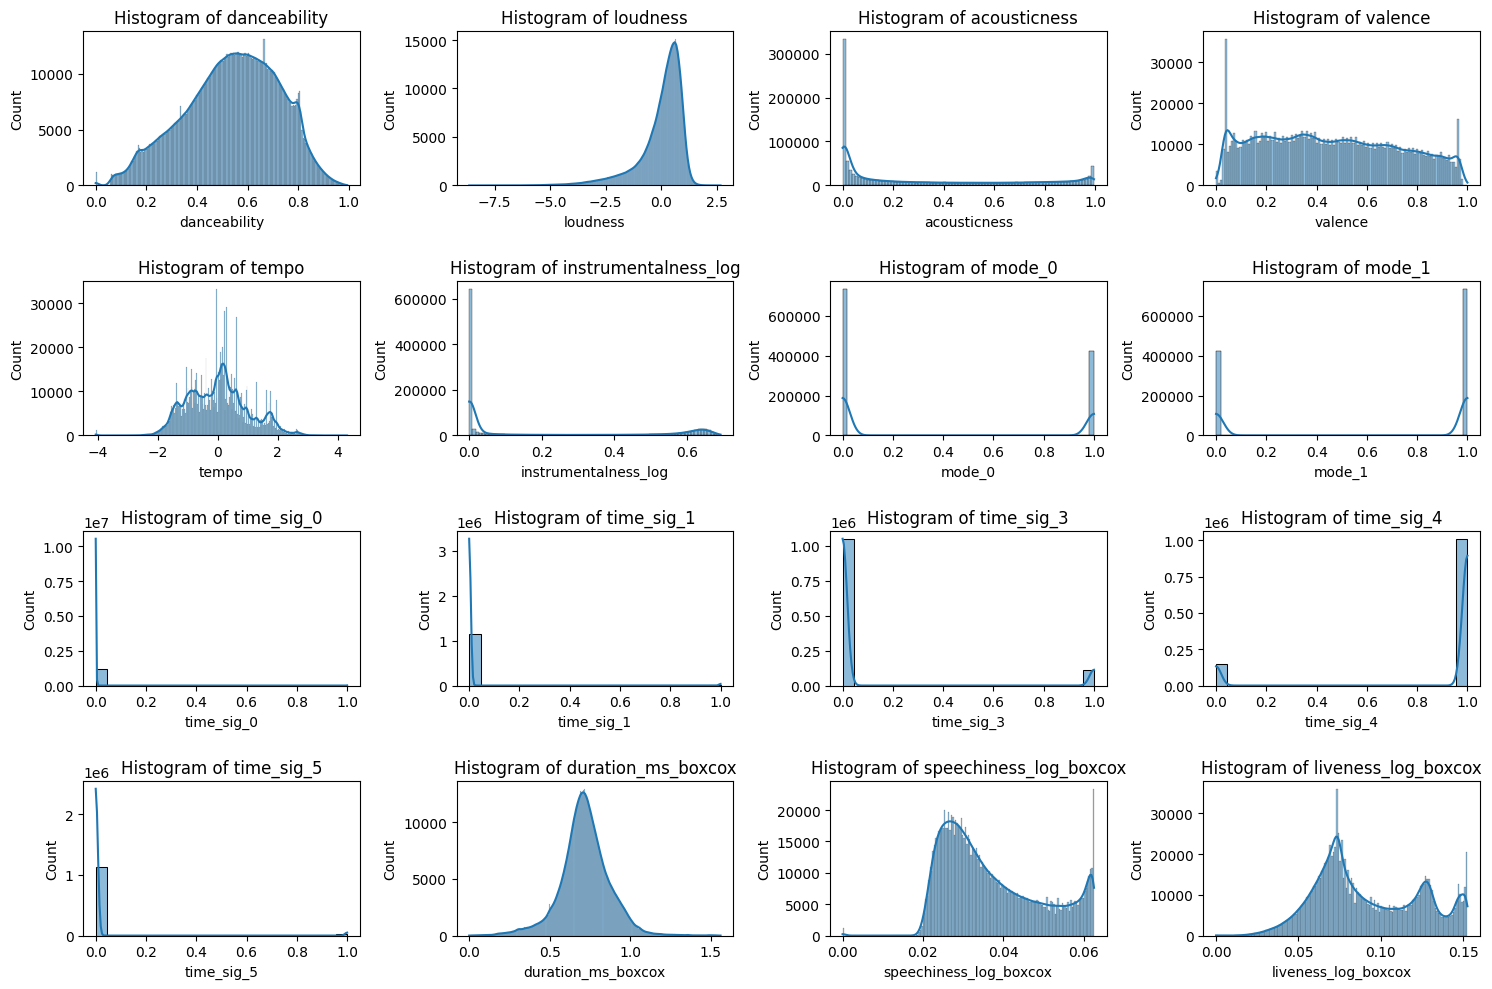

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))


num_features = len(numerical_features2_encoded)
num_rows = math.ceil(num_features / 4)  # Determine the number of rows needed

for i, feature in enumerate(numerical_features2_encoded, 1):
    plt.subplot(num_rows, 4, i)  # Update the number of rows here
    sns.histplot(data2_encoded[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()  # Adjust the layout
plt.show()


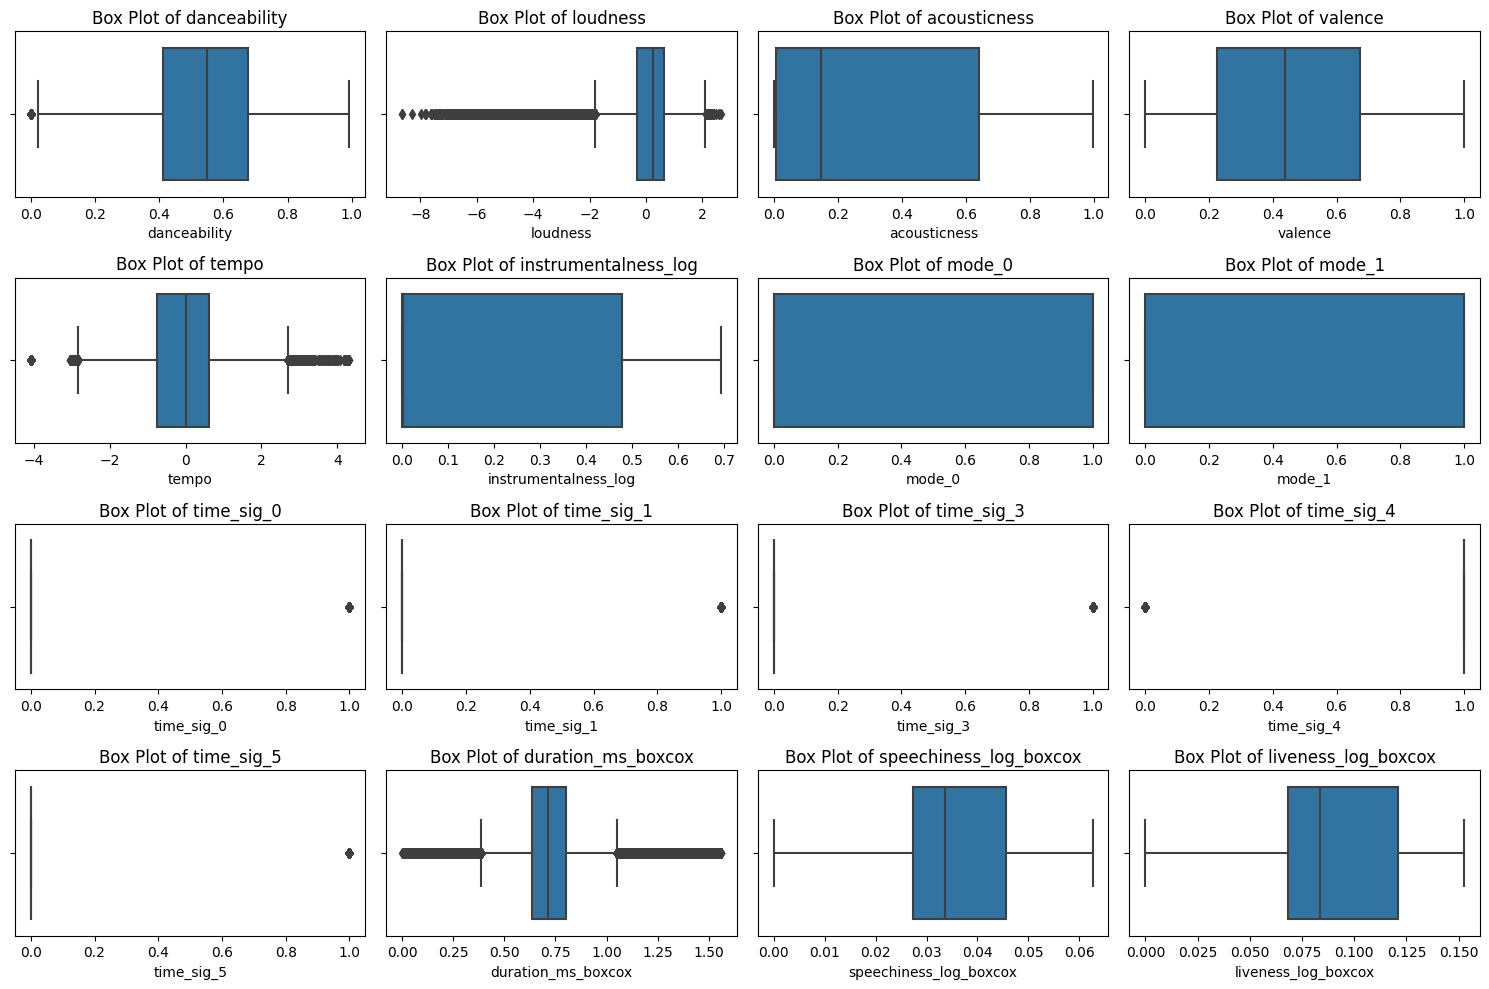

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


num_features = len(numerical_features2_encoded)
num_cols = 4  # You can keep the number of columns as 4 or adjust as necessary
num_rows = math.ceil(num_features / num_cols)  # Calculate the required number of rows

plt.figure(figsize=(15, num_rows * 2.5))  # Adjust the figure size as needed

for i, feature in enumerate(numerical_features2_encoded, 1):
    plt.subplot(num_rows, num_cols, i)  # Update the number of rows and columns
    sns.boxplot(x=data2_encoded[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()  # Adjust the layout
plt.show()


# Handling Outliers and dropping variables


In [ ]:
"""
from scipy import stats
import pandas as pd
z_scores = stats.zscore(data2_encoded)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data2_cleaned = data2_encoded[filtered_entries]
"""

'\nfrom scipy import stats\nimport pandas as pd\nz_scores = stats.zscore(data2_encoded)\nabs_z_scores = np.abs(z_scores)\nfiltered_entries = (abs_z_scores < 3).all(axis=1)\ndata2_cleaned = data2_encoded[filtered_entries]\n'

In [ ]:
"""print(data2_cleaned.columns)
data2_cleaned.shape"""

'print(data2_cleaned.columns)\ndata2_cleaned.shape'

In [17]:
numerical_features2_encoded=['danceability', 'loudness', 'acousticness', 'valence', 'tempo', 'instrumentalness_log', 'mode_0', 'mode_1',
       'time_sig_0', 'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5',
       'duration_ms_boxcox', 'speechiness_log_boxcox', 'liveness_log_boxcox']
print(numerical_features2_encoded)


['danceability', 'loudness', 'acousticness', 'valence', 'tempo', 'instrumentalness_log', 'mode_0', 'mode_1', 'time_sig_0', 'time_sig_1', 'time_sig_3', 'time_sig_4', 'time_sig_5', 'duration_ms_boxcox', 'speechiness_log_boxcox', 'liveness_log_boxcox']


Split the Data into Training and Test

In [18]:
X_cleaned = data2_encoded[numerical_features2_encoded]

y_cleaned = data2_encoded['popularity']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.35, random_state=42)


In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(753846, 16)
(753846,)
(405918, 16)
(405918,)


In [21]:
print(X_train.describe())
print(y_train.describe())
print(X_test.describe())
print(y_test.describe())

        danceability       loudness   acousticness        valence  \
count  753846.000000  753846.000000  753846.000000  753846.000000   
mean        0.537375       0.000458       0.321640       0.455427   
std         0.184518       1.000020       0.355049       0.268485   
min         0.000000      -8.644282       0.000000       0.000000   
25%         0.413000      -0.325163       0.006420       0.226000   
50%         0.550000       0.269763       0.147000       0.438000   
75%         0.677000       0.652097       0.641000       0.674000   
max         0.993000       2.666805       0.996000       1.000000   

               tempo  instrumentalness_log         mode_0         mode_1  \
count  753846.000000         753846.000000  753846.000000  753846.000000   
mean        0.000016              0.187530       0.365630       0.634370   
std         0.999931              0.263956       0.481607       0.481607   
min        -4.075830              0.000000       0.000000       0.000000  

Run Regressions

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
# Initialize the Linear Regression model
linear_reg_model = LinearRegression()

# Train the model on the training data
model=linear_reg_model.fit(X_train, y_train)



# Add a constant to the input features to include the intercept in the model
X_train_with_const = sm.add_constant(X_train)

# Fit the OLS model using statsmodels
sm_model = sm.OLS(y_train, X_train_with_const).fit()

# Get the summary of the regression
summary = sm_model.summary()
print(summary)

# Make predictions on the testing data
linear_reg_predictions = linear_reg_model.predict(X_test)

# Evaluate the model
linear_reg_rmse = mean_squared_error(y_test, linear_reg_predictions, squared=False)
linear_reg_r2 = r2_score(y_test, linear_reg_predictions)
linear_reg_rmse2 = np.sqrt(mean_squared_error(y_test, linear_reg_predictions))

linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)
linear_reg_evs = explained_variance_score(y_test, linear_reg_predictions)
linear_reg_medae = median_absolute_error(y_test, linear_reg_predictions)
# Calculate adjusted R-squared for Linear Regression
n = X_test.shape[0]  # Number of samples
p = X_test.shape[1]  # Number of predictors
adj_r2_linear_reg = 1 - ((1 - linear_reg_r2) * (n - 1) / (n - p - 1))

# Display Linear Regression evaluation metrics
print("Linear Regression Evaluation Metrics:")
print(f"RMSE: {linear_reg_rmse:.2f}")
print(f"R-squared: {linear_reg_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_linear_reg:.2f}")
print(f"MAE: {linear_reg_mae:.2f}")
print(f"Explained Variance Score: {linear_reg_evs:.2f}")
print(f"Median Absolute Error: {linear_reg_medae:.2f}")


                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3891.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        03:04:25   Log-Likelihood:            -3.1281e+06
No. Observations:              753846   AIC:                         6.256e+06
Df Residuals:                  753831   BIC:                         6.256e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     19

Hyperparameter tuning for RandomForest

In [25]:
"""from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Example using GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
    }

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

# Make predictions on the testing data
best_rf_predictions = best_rf_model.predict(X_test)

# Evaluate the model
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_predictions))
best_rf_r2 = r2_score(y_test, best_rf_predictions)
best_rf_mae = mean_absolute_error(y_test, best_rf_predictions)
best_rf_evs = explained_variance_score(y_test, best_rf_predictions)
best_rf_medae = median_absolute_error(y_test, best_rf_predictions)

# Calculate adjusted R-squared for Random Forest Regression
adj_r2_best_rf = 1 - ((1 - best_rf_r2) * (n - 1) / (n - p - 1))

# Display Random Forest Regression evaluation metrics
print("\nRandom Forest Regression Evaluation Metrics:")
print(f"RMSE: {best_rf_rmse:.2f}")
print(f"R-squared: {best_rf_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_best_rf:.2f}")
print(f"MAE: {best_rf_mae:.2f}")
print(f"Explained Variance Score: {best_rf_evs:.2f}")
print(f"Median Absolute Error: {best_rf_medae:.2f}")"""

Fitting 2 folds for each of 432 candidates, totalling 864 fits


TerminatedWorkerError: ignored

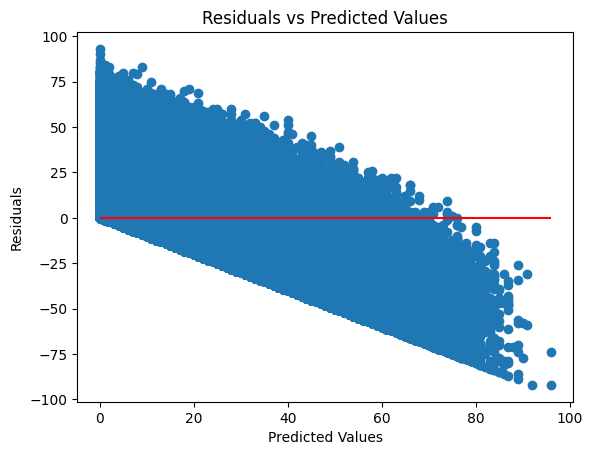

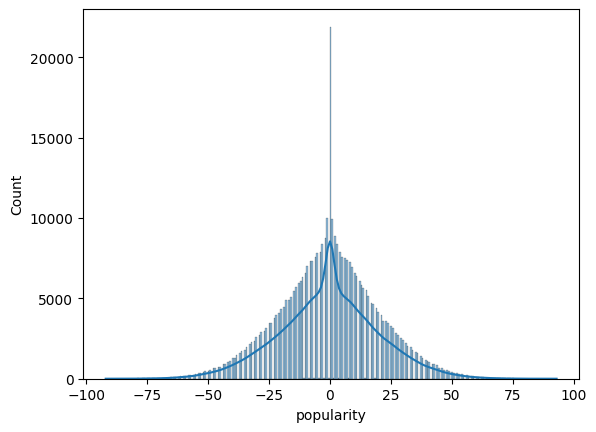


Decision Tree Regression Evaluation Metrics:
RMSE: 20.34
R-squared: -0.64
Adjusted R-squared: -0.64
MAE: 15.55
Explained Variance Score: -0.64
Median Absolute Error: 12.00


In [26]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing data
decision_tree_predictions = decision_tree_model.predict(X_test)

# Evaluate the model
decision_tree_rmse = np.sqrt(mean_squared_error(y_test, decision_tree_predictions))
decision_tree_r2 = r2_score(y_test, decision_tree_predictions)
decision_tree_mae = mean_absolute_error(y_test, decision_tree_predictions)
decision_tree_evs = explained_variance_score(y_test, decision_tree_predictions)
decision_tree_medae = median_absolute_error(y_test, decision_tree_predictions)
# Calculate adjusted R-squared for Decision Tree Regression
adj_r2_decision_tree = 1 - ((1 - decision_tree_r2) * (n - 1) / (n - p - 1))

# Calculate residuals
residuals = y_test - decision_tree_predictions

# Plot residuals
plt.scatter(decision_tree_predictions, residuals)
plt.hlines(y=0, xmin=decision_tree_predictions.min(), xmax=decision_tree_predictions.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Check for normality of residuals
sns.histplot(residuals, kde=True)
plt.show()

# Display Decision Tree Regression evaluation metrics
print("\nDecision Tree Regression Evaluation Metrics:")
print(f"RMSE: {decision_tree_rmse:.2f}")
print(f"R-squared: {decision_tree_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_decision_tree:.2f}")
print(f"MAE: {decision_tree_mae:.2f}")
print(f"Explained Variance Score: {decision_tree_evs:.2f}")
print(f"Median Absolute Error: {decision_tree_medae:.2f}")


In [27]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Random Forest Regression model
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the testing data
random_forest_predictions = random_forest_model.predict(X_test)

# Evaluate the model
random_forest_rmse = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
random_forest_r2 = r2_score(y_test, random_forest_predictions)
random_forest_mae = mean_absolute_error(y_test, random_forest_predictions)
random_forest_evs = explained_variance_score(y_test, random_forest_predictions)
random_forest_medae = median_absolute_error(y_test, random_forest_predictions)

# Calculate adjusted R-squared for Random Forest Regression
adj_r2_random_forest = 1 - ((1 - random_forest_r2) * (n - 1) / (n - p - 1))

# Display Random Forest Regression evaluation metrics
print("\nRandom Forest Regression Evaluation Metrics:")
print(f"RMSE: {random_forest_rmse:.2f}")
print(f"R-squared: {random_forest_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_random_forest:.2f}")
print(f"MAE: {random_forest_mae:.2f}")
print(f"Explained Variance Score: {random_forest_evs:.2f}")
print(f"Median Absolute Error: {random_forest_medae:.2f}")


Random Forest Regression Evaluation Metrics:
RMSE: 14.25
R-squared: 0.19
Adjusted R-squared: 0.19
MAE: 11.44
Explained Variance Score: 0.20
Median Absolute Error: 9.90


In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha parameter for regularization
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
lasso_predictions = lasso_model.predict(X_test)

# Calculate evaluation metrics for Lasso Regression
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_mae = mean_absolute_error(y_test, lasso_predictions)
lasso_evs = explained_variance_score(y_test, lasso_predictions)
lasso_medae = median_absolute_error(y_test, lasso_predictions)

# Calculate adjusted R-squared for Lasso Regression
adj_r2_lasso = 1 - ((1 - lasso_r2) * (n - 1) / (n - p - 1))

# Display Lasso Regression evaluation metrics
print("\nLasso Regression Evaluation Metrics:")
print(f"RMSE: {lasso_rmse:.2f}")
print(f"R-squared: {lasso_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_lasso:.2f}")
print(f"MAE: {lasso_mae:.2f}")
print(f"Explained Variance Score: {lasso_evs:.2f}")
print(f"Median Absolute Error: {lasso_medae:.2f}")


Lasso Regression Evaluation Metrics:
RMSE: 15.83
R-squared: 0.01
Adjusted R-squared: 0.01
MAE: 13.04
Explained Variance Score: 0.01
Median Absolute Error: 12.31


In [29]:
from sklearn.linear_model import Ridge

# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
ridge_predictions = ridge_model.predict(X_test)

# Calculate evaluation metrics for Ridge Regression
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_evs = explained_variance_score(y_test, ridge_predictions)
ridge_medae = median_absolute_error(y_test, ridge_predictions)

# Calculate adjusted R-squared for Ridge Regression
adj_r2_ridge = 1 - ((1 - ridge_r2) * (n - 1) / (n - p - 1))

# Display Ridge Regression evaluation metrics
print("\nRidge Regression Evaluation Metrics:")
print(f"RMSE: {ridge_rmse:.2f}")
print(f"R-squared: {ridge_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_ridge:.2f}")
print(f"MAE: {ridge_mae:.2f}")
print(f"Explained Variance Score: {ridge_evs:.2f}")
print(f"Median Absolute Error: {ridge_medae:.2f}")



Ridge Regression Evaluation Metrics:
RMSE: 15.35
R-squared: 0.07
Adjusted R-squared: 0.07
MAE: 12.59
Explained Variance Score: 0.07
Median Absolute Error: 11.59


In [30]:
from xgboost import XGBRegressor

# Initialize and train the XGBoost Regression model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Calculate evaluation metrics for XGBoost Regression
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_evs = explained_variance_score(y_test, xgb_predictions)
xgb_medae = median_absolute_error(y_test, xgb_predictions)

# Calculate adjusted R-squared for XGBoost Regression (Note: XGBoost doesn't directly provide R-squared)
adj_r2_xgb = 1 - ((1 - xgb_r2) * (n - 1) / (n - p - 1))

# Display XGBoost Regression evaluation metrics
print("\nXGBoost Regression Evaluation Metrics:")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R-squared: {xgb_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_xgb:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"Explained Variance Score: {xgb_evs:.2f}")
print(f"Median Absolute Error: {xgb_medae:.2f}")



XGBoost Regression Evaluation Metrics:
RMSE: 14.20
R-squared: 0.20
Adjusted R-squared: 0.20
MAE: 11.39
Explained Variance Score: 0.20
Median Absolute Error: 9.84


In [31]:
"""import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 0.1, 0.5, 0]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize the Random Search
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=3, verbose=2)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters found
print(f"Best parameters found: {random_search.best_params_}")
"""
# Train the model with the best parameters found
best_regressor = XGBRegressor(
    subsample=0.8,
    reg_lambda=0.5,
    reg_alpha=0.1,
    n_estimators=200,
    min_child_weight=2,
    max_depth=7,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.7
)
best_regressor.fit(X_train, y_train)

# Make predictions on the test set
best_xgb_predictions = best_regressor.predict(X_test)

# Calculate evaluation metrics for XGBoost Regression
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, best_xgb_predictions))
best_xgb_r2 = r2_score(y_test, best_xgb_predictions)
best_xgb_mae = mean_absolute_error(y_test, best_xgb_predictions)
best_xgb_evs = explained_variance_score(y_test, best_xgb_predictions)
best_xgb_medae = median_absolute_error(y_test, best_xgb_predictions)

# Calculate adjusted R-squared for XGBoost Regression (Note: XGBoost doesn't directly provide R-squared)
adj_r2_best_xgb = 1 - ((1 - best_xgb_r2) * (n - 1) / (n - p - 1))

# Display XGBoost Regression evaluation metrics
print("\nXGBoost Regression Evaluation Metrics:")
print(f"RMSE: {best_xgb_rmse:.2f}")
print(f"R-squared: {best_xgb_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_best_xgb:.2f}")
print(f"MAE: {best_xgb_mae:.2f}")
print(f"Explained Variance Score: {best_xgb_evs:.2f}")
print(f"Median Absolute Error: {best_xgb_medae:.2f}")


XGBoost Regression Evaluation Metrics:
RMSE: 14.16
R-squared: 0.21
Adjusted R-squared: 0.21
MAE: 11.37
Explained Variance Score: 0.21
Median Absolute Error: 9.84


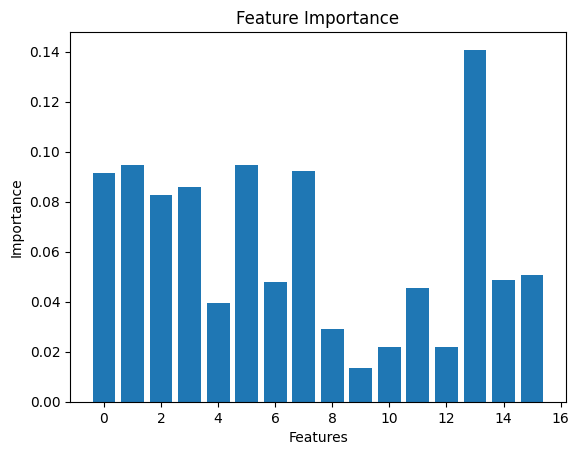

In [43]:
# Get feature importances
feature_importances = best_regressor.feature_importances_

# Visualize feature importances
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [32]:
best_xgb_params= {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}

In [33]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and train the KNN Regression model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (K)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_predictions = knn_model.predict(X_test)

# Calculate evaluation metrics for KNN Regression
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_predictions))
knn_r2 = r2_score(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_evs = explained_variance_score(y_test, knn_predictions)
knn_medae = median_absolute_error(y_test, knn_predictions)

# Calculate adjusted R-squared for KNN Regression (Note: KNN doesn't directly provide R-squared)
adj_r2_knn = 1 - ((1 - knn_r2) * (n - 1) / (n - p - 1))

# Display KNN Regression evaluation metrics
print("\nKNN Regression Evaluation Metrics:")
print(f"RMSE: {knn_rmse:.2f}")
print(f"R-squared: {knn_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2_knn:.2f}")
print(f"MAE: {knn_mae:.2f}")
print(f"Explained Variance Score: {knn_evs:.2f}")
print(f"Median Absolute Error: {knn_medae:.2f}")




KNN Regression Evaluation Metrics:
RMSE: 15.66
R-squared: 0.03
Adjusted R-squared: 0.03
MAE: 12.42
Explained Variance Score: 0.03
Median Absolute Error: 10.40


In [34]:
#ElasticNet Regression:
from sklearn.linear_model import ElasticNet

# Initialize and train the ElasticNet Regression model
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # You can adjust alpha and l1_ratio
elastic_net_model.fit(X_train, y_train)

# Make predictions on the test set
elastic_net_predictions = elastic_net_model.predict(X_test)

# Calculate evaluation metrics for ElasticNet Regression
elastic_net_rmse = np.sqrt(mean_squared_error(y_test, elastic_net_predictions))
elastic_net_r2 = r2_score(y_test, elastic_net_predictions)
elastic_net_mae = mean_absolute_error(y_test, elastic_net_predictions)
elastic_net_evs = explained_variance_score(y_test, elastic_net_predictions)
elastic_net_medae = median_absolute_error(y_test, elastic_net_predictions)

# Calculate adjusted R-squared for ElasticNet Regression (if needed)
# n and p are the same as in the previous code
adj_r2_elastic_net = 1 - (1 - elastic_net_r2) * ((n - 1) / (n - p - 1))

# Display ElasticNet Regression evaluation metrics
print("\nElasticNet Regression Evaluation Metrics:")
print(f"RMSE: {elastic_net_rmse:.2f}")
print(f"R-squared: {elastic_net_r2:.2f}")
print(f"Adjusted R-squared for Elastic Net: {adj_r2_elastic_net:.2f}")
print(f"MAE: {elastic_net_mae:.2f}")
print(f"Explained Variance Score: {elastic_net_evs:.2f}")
print(f"Median Absolute Error: {elastic_net_medae:.2f}")



ElasticNet Regression Evaluation Metrics:
RMSE: 15.82
R-squared: 0.01
Adjusted R-squared for Elastic Net: 0.01
MAE: 13.03
Explained Variance Score: 0.01
Median Absolute Error: 12.29


In [42]:
 summary(elastic_net_model)
 elastic_net_model




TypeError: ignored

In [35]:
import tensorflow as tf
from tensorflow import keras
# Ensure that your training and testing data are of type float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Define and compile the model (same as before)
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions on the test set
nn_predictions = model.predict(X_test)

# Calculate evaluation metrics for the neural network (same as before)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
nn_r2 = r2_score(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_evs = explained_variance_score(y_test, nn_predictions)
nn_medae = median_absolute_error(y_test, nn_predictions)

# Calculate adjusted R-squared for the neural network (if needed)
# n and p are the same as in the previous code
adj_r2_neural_network = 1 - (1 - nn_r2) * ((n - 1) / (n - p - 1))
# Display neural network evaluation metrics (same as before)
print("Neural Network (Deep Learning) Evaluation Metrics:")
print(f"RMSE: {nn_rmse:.2f}")
print(f"R-squared: {nn_r2:.2f}")
print(f"Adjusted R-squared for Neural Network: {adj_r2_neural_network:.2f}")
print(f"MAE: {nn_mae:.2f}")
print(f"Explained Variance Score: {nn_evs:.2f}")
print(f"Median Absolute Error: {nn_medae:.2f}")


12685/12685 [==============================] - 12s 910us/step
Neural Network (Deep Learning) Evaluation Metrics:
RMSE: 14.32
R-squared: 0.19
Adjusted R-squared for Neural Network: 0.19
MAE: 11.41
Explained Variance Score: 0.19
Median Absolute Error: 9.76


In [36]:
import pandas as pd

# Create a dictionary to store evaluation metrics for each model
evaluation_metrics = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Ridge Regression', 'Lasso Regression', 'KNN', 'XGBoost Regressor', 'ElasticNet', 'Neural Network', 'Best XGBoost Regressor'],
    'RMSE': [linear_reg_rmse, decision_tree_rmse, random_forest_rmse, ridge_rmse, lasso_rmse,
             knn_rmse, xgb_rmse, elastic_net_rmse,nn_rmse, best_xgb_rmse],
    'R-squared': [linear_reg_r2, decision_tree_r2, random_forest_r2, ridge_r2, lasso_r2,
                    knn_r2, xgb_r2, elastic_net_r2, nn_r2, best_xgb_r2],
    'MAE': [linear_reg_mae, decision_tree_mae, random_forest_mae, ridge_mae, lasso_mae,
              knn_mae, xgb_mae, elastic_net_mae, nn_mae, best_xgb_mae],
    'Explained Variance': [linear_reg_evs, decision_tree_evs, random_forest_evs, ridge_evs, lasso_evs,
                            knn_evs, xgb_evs,  elastic_net_evs, nn_evs, best_xgb_evs],
    'Median Absolute Error': [linear_reg_medae, decision_tree_medae, random_forest_medae, ridge_medae, lasso_medae,
                               knn_medae, xgb_medae, elastic_net_medae, nn_medae, best_xgb_medae],
    'Adjusted R-squared': [adj_r2_linear_reg, adj_r2_decision_tree, adj_r2_random_forest,
                           adj_r2_ridge, adj_r2_lasso, adj_r2_knn, adj_r2_xgb,adj_r2_elastic_net, adj_r2_neural_network, adj_r2_best_xgb]

}

# Create a DataFrame from the dictionary
df = pd.DataFrame(evaluation_metrics)

# Display the DataFrame
print(df)

def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    max_color = 'background-color: red'
    min_color = 'background-color: yellow'
    return [max_color if v else min_color if u else '' for u, v in zip(is_min, is_max)]

# Apply the styling function to the numeric columns
styled_df = df.style.apply(highlight_max_min, subset=['RMSE', 'R-squared', 'MAE', 'Explained Variance', 'Median Absolute Error', 'Adjusted R-squared'])

# Display the styled DataFrame
styled_df

                    Model       RMSE  R-squared        MAE  \
0       Linear Regression  15.346251   0.066723  12.589490   
1           Decision Tree  20.338029  -0.639169  15.553322   
2           Random Forest  14.254831   0.194751  11.444017   
3        Ridge Regression  15.346230   0.066726  12.589592   
4        Lasso Regression  15.830767   0.006861  13.041065   
5                     KNN  15.657476   0.028485  12.418056   
6       XGBoost Regressor  14.198060   0.201152  11.385191   
7              ElasticNet  15.819866   0.008229  13.032749   
8          Neural Network  14.319292   0.187452  11.409928   
9  Best XGBoost Regressor  14.161470   0.205264  11.366788   

   Explained Variance  Median Absolute Error  Adjusted R-squared  
0            0.066723              11.592066            0.066686  
1           -0.638257              12.000000           -0.639234  
2            0.195519               9.901500            0.194719  
3            0.066726              11.593151     

,Model,RMSE,R-squared,MAE,Explained Variance,Median Absolute Error,Adjusted R-squared
0,Linear Regression,15.346251,0.066723,12.589490,0.066723,11.592066,0.066686
1,Decision Tree,20.338029,-0.639169,15.553322,-0.638257,12.000000,-0.639234
2,Random Forest,14.254831,0.194751,11.444017,0.195519,9.901500,0.194719
3,Ridge Regression,15.346230,0.066726,12.589592,0.066726,11.593151,0.066689
4,Lasso Regression,15.830767,0.006861,13.041065,0.006861,12.310495,0.006822
5,KNN,15.657476,0.028485,12.418056,0.028693,10.400000,0.028447
6,XGBoost Regressor,14.198060,0.201152,11.385191,0.201153,9.840581,0.201121
7,ElasticNet,15.819866,0.008229,13.032749,0.008229,12.290535,0.008189
8,Neural Network,14.319292,0.187452,11.409928,0.191650,9.764688,0.187420
9,Best XGBoost Regressor,14.161470,0.205264,11.366788,0.205265,9.840313,0.205233


Hyperparameter Tuning for Neural Net


In [37]:
"""from sklearn.neural_network import MLPRegressor

# Example using GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPRegressor(max_iter=100)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_mlp_model = grid_search.best_estimator_"""


'from sklearn.neural_network import MLPRegressor\n\n# Example using GridSearchCV\nparam_grid = {\n    \'hidden_layer_sizes\': [(50,50,50), (50,100,50), (100,)],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'sgd\', \'adam\'],\n    \'alpha\': [0.0001, 0.05],\n    \'learning_rate\': [\'constant\',\'adaptive\'],\n}\n\nmlp = MLPRegressor(max_iter=100)\ngrid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)\ngrid_search.fit(X_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nbest_mlp_model = grid_search.best_estimator_'

In [38]:
"""pip install keras-tuner
import kerastuner as kt

def build_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(
            units=hp.Int('units_1', min_value=32, max_value=512, step=32),
            activation='relu',
            input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(
            units=hp.Int('units_2', min_value=32, max_value=512, step=32),
            activation='relu'
        ),
        keras.layers.Dense(1)  # Output layer for regression
    ])

    # You can also search for the optimal learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model"""


"pip install keras-tuner\nimport kerastuner as kt\n\ndef build_model(hp):\n    model = keras.Sequential([\n        keras.layers.Dense(\n            units=hp.Int('units_1', min_value=32, max_value=512, step=32),\n            activation='relu',\n            input_shape=(X_train.shape[1],)\n        ),\n        keras.layers.Dense(\n            units=hp.Int('units_2', min_value=32, max_value=512, step=32),\n            activation='relu'\n        ),\n        keras.layers.Dense(1)  # Output layer for regression\n    ])\n\n    # You can also search for the optimal learning rate\n    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])\n\n    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),\n                  loss='mean_squared_error',\n                  metrics=['mae'])\n\n    return model"

In [ ]:
"""# Build the model with the best hyperparameters
model1 = tuner1.hypermodel.build(best_hps1)
model2 = tuner2.hypermodel.build(best_hps2)
model3 = tuner3.hypermodel.build(best_hps3)
model4 = tuner4.hypermodel.build(best_hps4)
# Train the best model
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
eval_result1 = model1.evaluate(X_test, y_test)
print("[test loss, test mae]:", eval_result1)
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
eval_result2 = model2.evaluate(X_test, y_test)
print("[test loss, test mae]:", eval_result2)
history3 = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
eval_result3 = model3.evaluate(X_test, y_test)
print("[test loss, test mae]:", eval_result3)
history4 = model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
eval_result4 = model4.evaluate(X_test, y_test)
print("[test loss, test mae]:", eval_result4)
"""

Cross Validation for RandomForest

In [ ]:
"""from sklearn.model_selection import cross_val_score

# For Random Forest
rf_cv_scores = cross_val_score(best_rf_model, X, y, cv=5)
print(f"Random Forest CV scores: {rf_cv_scores}")"""

Cross Validation for Neural Network


In [ ]:
"""# For Neural Network
mlp_cv_scores = cross_val_score(best_mlp_model, X, y, cv=5)
print(f"Neural Network CV scores: {mlp_cv_scores}")"""